#### Learning Structure
* k: # of groups, or # of containers
* one buffer
* a member in buffer will be examined against all of newly learned distrance, all quantified distance metrics will be ranked by p-value in descending order. The top distance metrics is the one chosen for the user.
* member of a container will be examined for the distance metrics learned for the population. If the member is not cosider enjoy a good fit of the distance metrics, the member will be checked with other alternative distance metris. Until at least one of qualified distance metrics found, the member is sent to the buffer.
* overall fit is measured by the following metrics
$$
fs_1 = \sum_{j = 1}^{k} (\sum_{i \in U_{j}} \text{P-value}(u_i,D_j)_{i} / |U_{j}|) + C \cdot |\text{buffer}|
$$

$$
fs_2 = \sum_{j = 1}^{k} (\sum_{i \in U_{j}} \text{P-value}(u_i,D_j)_{i} / |U_{j}|^2) + C \cdot |\text{buffer}|
$$

$$
fs_3 = \sum_{j = 1}^{k} (\sum_{i \in U_{j}} \text{P-value}(u_i,D_j)_{i} \cdot \frac{N}{|U_{j}|^2}) + C \cdot |\text{buffer}|
$$

* $u_i$: $i$th user
* $D_j$: the distance metrics learned for $j$th user group
* $U_j$: $j$th user group
* $|\cdot|$: size of users in the container
* $C$: the parameter determines the strength of penalty for more members in the buffer
* $N$: the total number of users in fit group, $\sum_{j = 1}^{k} |U_{j}|$

In [53]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import networkx as nx

from timeit import timeit

from matplotlib import pyplot as plt
from learning_dist_metrics import ldm

#from GWDLearner import *

%matplotlib inline

In [199]:
import scipy as sp
import numpy as np
import pandas as pd

from scipy.stats import rayleigh
from scipy.stats import ks_2samp
from numpy import linspace
from numpy.random import choice
from networkx import Graph
from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.dist_metrics import weighted_euclidean


def user_grouped_dist(user_id, weights, profile_df, friend_networkx):
    """ Calculate distances between a user and whose friends
        and distance between a user and whose non-friends.
        The groupped distance vector will be output.

    Parameters:
    ----------
    * user_id: {integer}, the target user's ID
    * weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    * profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    * friend_networkx: {networkx.Graph()}, Graph() object from Networkx
        to store the relationships informat
    Returns:
    -------
    res: {list, list of integers}, a list of two lists, which store the distances
        of either friends and non-friends separately.

    Examples:
    ---------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[ ["ID"] + cols ]
    user_dist = user_grouped_dist(user_id = 0, weights = weights
        , profile_df, friends_df)
    print user_dist["friends"]
    print user_dist["nonfriends"]
    """
    cols = [col for col in profile_df.columns if col is not "ID"]
    # get the user profile information of the target users
    # user_profile = profile_df.ix[profile_df.ID == user_id, cols].as_matrix()
    user_row = profile_df.ix[profile_df.ID == user_id, cols]
    user_profile = user_row.values.tolist()[0]
    # get the user_id of friends of the target user
    friends_ls = friend_networkx.neighbors(user_id)
    all_ids = profile_df.ID
    non_friends_ls = [u for u in all_ids if u not in friends_ls + [user_id]]

    sim_dist_vec = []
    for f_id in friends_ls:
        # friend_profile = profile_df.ix[profile_df.ID == f_id, cols].as_matrix()
        friend_row = profile_df.ix[profile_df.ID == f_id, cols]
        friend_profile = friend_row.values.tolist()[0]
        the_dist = weighted_euclidean(user_profile, friend_profile, weights)
        sim_dist_vec.append(the_dist)

    diff_dist_vec = []
    for nf_id in non_friends_ls:
        nonfriend_profile = profile_df.ix[profile_df.ID == nf_id, cols].as_matrix()
        the_dist = weighted_euclidean(user_profile, nonfriend_profile, weights)
        diff_dist_vec.append(the_dist)

    res = [sim_dist_vec, diff_dist_vec]
    return res


def user_dist_kstest(sim_dist_vec, diff_dist_vec,
                     fit_rayleigh=False, _n=100):

    """ Test the goodness of a given weights to defferentiate friend distance
        distributions and non-friend distance distributions of a given user.
        The distance distribution is considered to follow Rayleigh distribution.

    Parameters:
    ----------
    sim_dist_vec: {vector-like (list), float}, distances between friends
                  and the user
    diff_dist_vec: {vector-like (list), float}, distances between non-fri
                   -ends and the user
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution

    Returns:
    -------
    * res: {float}: p-value of ks-test with assumption that distances follow
            Rayleigh distribution.

    Examples:
    ---------
    pval = user_dist_kstest(sim_dist_vec, diff_dist_vec)
    """
    # is_valid = (len(sim_dist_vec) >= min_nobs) & \
    #           (len(diff_dist_vec) >= min_nobs) # not used yet
    if fit_rayleigh:
        friend_param = rayleigh.fit(sim_dist_vec)
        nonfriend_param = rayleigh.fit(diff_dist_vec)

        samp_friend = rayleigh.rvs(friend_param[0], friend_param[1], _n)
        samp_nonfriend = rayleigh.rvs(nonfriend_param[0], nonfriend_param[1], _n)

        # ouput p-value of ks-test
        res = ks_2samp(samp_friend, samp_nonfriend)[1]
    else:
        res = ks_2samp(sim_dist_vec, diff_dist_vec)[1]

    return res


def users_filter_by_weights(weights, profile_df, friends_networkx,
                            pval_threshold=0.5,
                            mutate_rate=0.4,
                            min_friend_cnt=10,
                            users_list=None,
                            fit_rayleigh=False,
                            _n=1000,
                            is_debug=False):
    """ Split users into two groups, "keep" and "mutate", with respect to
        p-value of the ks-test on the null hypothesis that the distribution of
        friends' weighted distance is not significantly different from the
        couterpart for non-friends. Assume the weighted distances of each group
        follow Rayleigh distribution.

    Parameters:
    ----------
    weights: {vector-like, float}, the vector of feature weights which
        is extracted by LDM().fit(x, y).get_transform_matrix()
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends_networkx: {networkx.Graph()}, Graph() object from Networkx to store
        the relationships information
    pval_threshold: {float}, the threshold for p-value to reject hypothesis
    min_friend_cnt: {integer}, drop users whose total of friends is less than
       this minimum count
    mutate_rate: {float}, a float value [0 - 1] determine the percentage of
       bad_fits member sent to mutation
    fit_rayleigh: {boolean}, determine if fit data into Rayleigth distri
                  -bution
    _n: {integer}, number of random samples generated from estimated
        distribution
    is_debug: {boolean}, to control if it yeilds by-product information

    Returns:
    -------
    res: {list} grouped list of user ids
        res[0] stores all users whose null hypothesis does not holds;
        res[1] stores all users whose null hypothesis hold null hypothesis,
        given weights, distance distribution of all friends is significantly
        different from distance distribution of all non-friends

    Examples:
    --------
    weights = ldm().fit(df, friends_list).get_transform_matrix()
    profile_df = users_df[["ID"] + cols]
    grouped_users = users_filter_by_weights(weights,
                       profile_df, friends_df, pval_threshold = 0.10,
                       min_friend_cnt = 10)

    Notes:
    -----
    min_friend_cnt is not implemented
    """
    # all_users_ids = list(set(profile_df.ID))
    # users_list
    # container for users meeting different critiria
    pvals = []
    if users_list is None:
        users_list = list(profile_df.ix[:, 0])

    for uid in users_list:
        res_dists = user_grouped_dist(uid, weights, profile_df, friends_networkx)
        pval = user_dist_kstest(res_dists[0], res_dists[1], fit_rayleigh, _n)
        pvals.append(pval)

    sorted_id_pval = sorted(zip(users_list, pvals), key=lambda x: x[1])

    if is_debug:
        good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
        bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]
        good_pvals = [p for i, p in sorted_id_pval if p < pval_threshold]
        bad_pvals = [p for i, p in sorted_id_pval if p >= pval_threshold]
    else:
        good_fits = [i for i, p in sorted_id_pval if p < pval_threshold]
        bad_fits = [i for i, p in sorted_id_pval if p >= pval_threshold]

    if len(bad_fits) > 0:
        mutate_size = np.ceil(len(bad_fits) * mutate_rate)
        mutate_size = max(int(mutate_size), 1)
        id_retain = good_fits + bad_fits[mutate_size:]
        id_mutate = bad_fits[:mutate_size]
        # split pval
        if is_debug:
            if len(good_pvals) > 0 or len(bad_pvals) > 0:
                pval_retain = good_pvals + bad_pvals[mutate_size:]
                pval_mutate = bad_pvals[mutate_size:]
    else:
        id_retain = good_fits
        id_mutate = bad_fits

        if is_debug:
            if len(good_pvals) > 0 or len(bad_pvals) > 0:
                pval_retain = pval_retain
                pval_mutate = bad_pvals

    if is_debug:
        res = [id_retain, id_mutate, pval_retain, pval_mutate]
    else:
        res = [id_retain, id_mutate]

    return res


def ldm_train_with_list(users_list, profile_df, friends, retain_type=1):
    """ learning distance matrics with ldm() instance, provided with selected
        list of users.

    Parameters:
    -----------
    users_list: {vector-like, integer}, the list of user id
    profile_df: {matrix-like, pandas.DataFrame}, user profile dataframe
        with columns: ["ID", "x0" - "xn"]
    friends: {list of tuple}, each tuple keeps a pair of user id
    retain_type: {integer}, 0, adopting 'or' logic by keeping relationship in
        friends_df if either of entities is in user_list 1, adopting 'and'
        logic

    Returns:
    -------
    res: {vector-like, float}, output of ldm.get_transform_matrix()

    Examples:
    ---------
    new_dist_metrics = ldm_train_with_list(user_list, profile_df, friends_df)
    """
    if retain_type == 0:
        friends = [(a, b) for a, b in friends if \
            a in users_list or b in users_list]
    else:
        friends = [(a, b) for a, b in friends if \
            a in users_list and b in users_list]
    
    ldm = LDM()    
    ldm.fit(profile_df, friends)
    weight_vec = ldm.get_transform_matrix()
    return weight_vec     


def init_embed_list(n):
    """
    """
    ls = []
    for i in range(n):
        ls.append([])
    return ls


def init_dict_list(k):
    """ create dictionary with k items, each
        item is a empty list
    """
    res_dict = {}
    for i in range(k):
        res_dict[i] = []
    return res_dict


def find_fit_group(uid, dist_metrics, profile_df,
                   friend_networkx, threshold=0.5,  current_group = None):
    """ calculate user p-value for the distance metrics of
        each group

    Parameters:
    ----------
    uid: {integer}, user id
    dist_metrics: {dictionary}, all {index: distance_metrics}
    profile_df: {DataFrame}, user profile includes "ID" column
    friend_networkx: {networkx.Graph}, user relationships
    threshold: {float}, threshold for qualifying pvalue of ks-test
    current_group: {integer}, group index

    Resutls:
    --------
    res: {list}, [group_idx, pvalue]
    """
    if current_group is None:
        other_group = dist_metrics.keys()
        other_dist_metrics = dist_metrics.values()
    else:
        other_group = [i for i in dist_metrics.keys() if i != current_group]
        other_dist_metrics = [d for g, d in dist_metrics.iteritems() if g != current_group]

    if len(other_dist_metrics) > 0:
        # only excute this is at least one alternative group
        pvals = []

        for d in other_dist_metrics:
            # loop through all distance metrics and calculate
            # p-value of ks-test by applying it to the user
            # relationships
            sdist, ddist = user_grouped_dist(user_id=uid, weights=d,
                        profile_df=profile_df, friend_networkx=friend_networkx)
            pval = user_dist_kstest(sim_dist_vec=sdist, diff_dist_vec=ddist,
                                fit_rayleigh=True, _n=1000)
            pvals.append(pval)

        min_pval = min(pvals)[0]
        min_index = [i for i, p in enumerate(pvals) if p == min_pval][0]
        best_group = other_group[min_index]

        if min_pval >= threshold:
            # if min_pval >= threshold, user is not considered
            # to have a good fit by any of distance metrics
            best_group = None
            min_pval = None

    else:
        best_group = None
        min_pval = None

    return (best_group, min_pval)

def get_fit_score(fit_pvals, buffer_group, c, t=2):
    """ calculate the fit score given the member composite
        and its pvalues with its group distance metrics, with
        c determinng the strength of penalty for keeping a 
        larger number of users in buffer_group
        
    Parameters:
    -----------
    fit_pvals: {dict}, {index: [pvalues]}
    buffer_group: {list}, [userid, ...]
    c: {float}, 
    t: {integer} 1, 2 or 3, type of fit score
    
    Returns:
    --------
    fit_score: {float}, fit score, a smaller value indidcate
                a overall better fit
    
    Examples:
    ---------
    fit_group = fit_group
    fit_pvals = fit_pvals
    buffer_group = buffer_group
    c = 0.1
    fscore = get_fit_score(fit_group, fit_pvals, buffer_group, c)
    """
    
    # weighted sum of pvalues 
    if t not in [1, 2, 3]:
        raise NameError('Error: type (t) is not legal value (1 or 2)!')
    
    wsum_pval = 0
    if t == 1:
        for g, v in fit_pvals.iteritems():
            wsum_pval += sum(np.array(v) * 1.0 / len(v))
    if t == 2:
        for g, v in fit_pvals.iteritems():
            wsum_pval += sum(np.array(v)) * 1.0 / (len(v) * len(v))
    if t == 3:
        num_users = 0
        for g, v in fit_pvals.iteritems():
            wsum_pval += sum(np.array(v)) * 1.0 / (len(v) * len(v))
            num_users += len(v)
        wsum_pval = num_users * 1.0 * wsum_pval

    penalty = c * len(buffer_group)
    fit_score = wsum_pval + penalty # smaller value indicates a better overall fit
    
    return fit_score

### Load the experiment data for analysis

In [55]:
user_df = pd.read_csv("data/drhuang_person.csv", header=0)
friend_df = pd.read_csv("data/drhuang_friend.csv", header=0,)

## split data by column
all_uids = user_df["ID"]
profile_df = user_df

In [62]:
relation_mtx = friend_df.ix[:, 1:]

friend_pairs = []
uid_row = friend_df.ix[:, 0]
uid_col = uid_row

# convert relationship matrix into a list of user pairs
# to represent friendships, iterating through items
# on the lower triangle of the matrix
for i, uid_a in enumerate(uid_row):
    for j, uid_b in enumerate(uid_col):

        if uid_a < uid_b:
            ind = relation_mtx.ix[i, j]
            if ind == 1:
                friend_pairs.append((uid_a, uid_b))

# load relationship into networkx.Graph()
from networkx import Graph

fnx = Graph()
fnx.add_edges_from(friend_pairs)

In [57]:
def scalar(x):
    _min, _max = min(x), max(x)
    _range = (_max - _min) * 1.0
    res = [(i - _min) / _range for i in x]
    return res

## transform data
new_profile_df = pd.DataFrame()

new_profile_df["ID"]        = uid_df #uid_df["ID"]
new_profile_df["Gender"]    = profile_df.ix[:, 0]
new_profile_df["Age"]       = scalar(profile_df["Age"])
new_profile_df["Region"]    = scalar(profile_df["Region"])
new_profile_df["Education"] = scalar(profile_df["Education"])
new_profile_df["Income"]    = scalar(profile_df["Income"])
new_profile_df["Hobby"]     = scalar(profile_df["Hobby"])
new_profile_df["Duration"]  = scalar(profile_df["Duration"])

#### Develop the iteractive learning framework

In [58]:
# new_profile_df.head(5)
# fnx
# friend_pairs

In [297]:
"""
input info.:
----------
profile_df
friend_networkx

control parameters:
-------------------
t: fit score type

tuning parameter:
-----------------
threshold: cutoff value for kstest
c: regularization strength
min_delta_f: threshold for significant improvement
max_iter: maxmium number of trivial trial learning in a row 
"""
# input info
k = 1 # user input

# user_profile

# final user interface
# necessary
# profile_df, 
# friends_ls
# fnx

profile_df = new_profile_df     # user profile
friends_ls = friend_pairs  # user relationship 
friend_networkx = fnx        # user friendswork

# tuing parameters
t = 2               # type of Fit Score formula
c = 0.1             # penalty for larger buffer group in Fit Score calculation
threshold = 0.5     # ks-test threshold for fit or not fit
n = 1000            # ks-test sample size for rayleigh 
min_size_group = 10 # minimal group size
min_delta_f = 0.02  # minimal reduction for a significant fit improvement
max_iter = 10       # max number of trivial iteration of learning

# initiate the containers:
dist_metrics = init_dict_list(k) # distance metrics containers
fit_group = init_dict_list(k)    # members composition in fit groups
fit_pvals = init_dict_list(k)    # members' pvalue of KStest with their group distance metrics
unfit_group = init_dict_list(k)  # members is not considerd fit by its group distance metrics
unfit_pvals = init_dict_list(k)  # pvalues for members in unfit_group (maybe can be deleted)
buffer_group = []                # members are not considered having fit

# results value
fs_hist = []       # list of fit scores in sequence (lastest one is the last)
knowledge_pkg = [] # {index: {"dist_metrics", "fit_group", "buffer_group"}} 

# calculate the the init distance metrics

# sampling is subset of users to calculate
# the distance metrics is good method

# dist_metrics: ldm() with subset of users
# fit_group: subsets of users
# buffer_group: useres are not sampled 

# provide initial composition of fit_group
# and buffer_group for iterative learning
# procedure
# the even sampling strategy is implemeted
# here, however, 
samp_size = len(all_uids) / k 
samp_sizes = [samp_size] * k
all_uids_copy = [i for i in all_uids]

# generate k groups of sample user groups
for g, samp_size in zip(range(k), samp_sizes):
    # draw samples and assign them to fit_group
    samples = choice(all_uids_copy, samp_size, replace=False)
    fit_group[g] = list(samples)
    # remove samples from population pool
    for uid in samples:
        all_uids_copy.remove(uid)

# initiate fit user pvals
for g, uids in fit_group.iteritems():
    fit_pvals[g] = [0] * len(uids)
        
# if len(all_uids_copy) > 0:
#     buffer_group = all_uids_copy
# else:
#    buffer_group = []

In [298]:
print fit_group
print buffer_group

{0: [6, 99, 14, 47, 36, 82, 55, 45, 5, 85, 10, 9, 40, 92, 93, 100, 8, 3, 22, 21, 54, 69, 94, 95, 70, 28, 24, 44, 25, 59, 90, 58, 68, 64, 13, 34, 11, 74, 18, 62, 57, 2, 72, 51, 29, 56, 96, 30, 75, 87, 37, 20, 97, 84, 49, 76, 15, 38, 19, 60, 31, 79, 65, 91, 42, 77, 1, 52, 80, 83, 46, 26, 7, 61, 53, 48, 89, 67, 73, 33, 50, 12, 66, 81, 71, 17, 39, 4, 98, 43, 41, 88, 86, 35, 78, 32, 27, 63, 23, 16]}
[]


In [299]:
# performance measurements
durations = []

_no_imp_counter = 0
_loop_counter = 0

print "******************** iterative learning begins ************************************"

while _no_imp_counter < max_iter:
    
    _loop_counter += 1
    print "%d iteration is in processing ..." % _loop_counter
    start_time = timeit()
    
    # step 01: learn distance metrics
    for g, uids in fit_group.iteritems():
        # learn distance metrics
        # here to update the computational mechanism
        # dist = [np.random.uniform(0, 1, 1)[0] for i in range(4)]
        if len(uids) >= min_size_group:
            dist = ldm_train_with_list(uids, profile_df, friends_ls)
            dist_metrics[g] = dist
        else:
            num_feat = profile_df.shape[1] - 1
            dist_metrics[g] = [1] * num_feat
        
    # step 02: update the member composite with updated group 
    # distance metrics threshold is needed to be defined
    fit_group_copy = {k:[i for i in v] for k, v in fit_group.iteritems()}
    for g, uids in fit_group_copy.iteritems():
        target_dist = dist_metrics[g]
        for uid in uids:
            sdist, ddist = user_grouped_dist(uid, target_dist, profile_df, 
                                         friend_networkx)
            pval = user_dist_kstest(sdist, ddist, fit_rayleigh=True, _n=n)
             
            if pval >= threshold:
                # remove the user and its information 
                # from relevant container
                idx = [i for i, u in enumerate(fit_group[g]) if u == uid][0]
                fit_group[g].pop(idx)
                # fit_group[g].remove(uid)
                fit_pvals[g].pop(idx)
                
                # add the user to the unfit_group
                if g in unfit_group:
                    unfit_group[g].append(uid)
                else:
                    unfit_group[g] = [uid]
            
            else:
                idx = [i for i, u in enumerate(fit_group[g]) if u == uid][0]
                fit_pvals[g][idx] = pval
                
    tot_fit_group = np.sum([len(u) for g, u in fit_group.iteritems()])
    tot_unfit_group = np.sum([len(u) for g, u in unfit_group.iteritems()])
    tot_buffer_group = len(buffer_group)
    print "1) #fit: %d, #unfit: %d, #buffer: %d" % (tot_fit_group, tot_unfit_group, tot_buffer_group)
                    
    # step 03: test members in unfit_group to see
    # if it has a good fit with other distmetrics
    # make a copy of the buffer group container
    buffer_group_copy = [i for i in buffer_group]
    if len(buffer_group_copy) > 0:
        for uid in buffer_group_copy:
            new_group, new_pval = find_fit_group(uid, dist_metrics, 
                                                 profile_df, friend_networkx, threshold)
            if new_group is not None:
                buffer_group.remove(uid)
                if new_group in fit_group:
                    fit_group[new_group].append(uid)
                    fit_pvals[new_group].append(new_pval)
                else:
                    fit_group[new_group] = [uid]
                    fit_pvals[new_group] = [new_pval]
                    
                    
    tot_fit_group = np.sum([len(u) for g, u in fit_group.iteritems()])
    tot_unfit_group = np.sum([len(u) for g, u in unfit_group.iteritems()])
    tot_buffer_group = len(buffer_group)
    print "2) #fit: %d, #unfit: %d, #buffer: %d" % (tot_fit_group, tot_unfit_group, tot_buffer_group)
                    
    unfit_group_copy = {k:[i for i in v] for k, v in unfit_group.iteritems()}
    for g, uids in unfit_group_copy.iteritems():
        for uid in uids:        
            new_group, new_pval = find_fit_group(uid, dist_metrics, profile_df, 
                                                 friend_networkx, threshold, g)
            unfit_group[g].remove(uid)

            if new_pval is None:
                buffer_group.append(uid)
            else:
                if new_group in fit_group:
                    fit_group[new_group].append(uid)
                    fit_pvals[new_group].append(new_pval)
                else:
                    fit_group[new_group] = [uid]
                    fit_pvals[new_group] = [new_pval]
                    
    tot_fit_group = np.sum([len(u) for g, u in fit_group.iteritems()])
    tot_unfit_group = np.sum([len(u) for g, u in unfit_group.iteritems()])
    tot_buffer_group = len(buffer_group)
    print "3) #fit: %d, #unfit: %d, #buffer: %d" % (tot_fit_group, tot_unfit_group, tot_buffer_group)
                        
    # step 04: calculate fit score
    fs = get_fit_score(fit_pvals, buffer_group, c=c, t=1)
    fs_hist.append(fs)
    
    # step 05: evaluate stop criteria
    package = {"dist_metrics": dist_metrics, 
               "fit_group": fit_group, 
               "buffer_group": buffer_group}

    knowledge_pkg.append(package)
    best_fs = min(fs_hist)

    if best_fs - fs <= min_delta_f:
        _no_imp_counter += _no_imp_counter 
    else:
        _no_imp_counter = 0
        if threshold > 0.2:
            threshold -= 0.01
        
    # print "fit score (type-%d): %.3f" % (t, fs)
    # print "best fit score: %.3f" % best_fs
    end_time = timeit()
    duration = end_time - start_time
    durations.append(duration)
    print "time elapsed: %.4f s" % duration
     
print "******************** ends ************************************"

******************** iterative learning begins ************************************
1 iteration is in processing ...
--- 185.58 seconds ---
1) #fit: 49, #unfit: 51, #buffer: 0
2) #fit: 49, #unfit: 51, #buffer: 0
3) #fit: 49, #unfit: 0, #buffer: 51
time elapsed: -0.0055 s
2 iteration is in processing ...
--- 341.57 seconds ---
1) #fit: 26, #unfit: 23, #buffer: 51
2) #fit: 49, #unfit: 23, #buffer: 28
3) #fit: 49, #unfit: 0, #buffer: 51
time elapsed: 0.0002 s
3 iteration is in processing ...
--- 207.97 seconds ---
1) #fit: 26, #unfit: 23, #buffer: 51
2) #fit: 51, #unfit: 23, #buffer: 26
3) #fit: 51, #unfit: 0, #buffer: 49
time elapsed: 0.0001 s
4 iteration is in processing ...
--- 159.47 seconds ---
1) #fit: 26, #unfit: 25, #buffer: 49
2) #fit: 47, #unfit: 25, #buffer: 28
3) #fit: 47, #unfit: 0, #buffer: 53
time elapsed: 0.0002 s
5 iteration is in processing ...
--- 175.47 seconds ---
1) #fit: 21, #unfit: 26, #buffer: 53
2) #fit: 46, #unfit: 26, #buffer: 28
3) #fit: 46, #unfit: 0, #buffer

ValueError: array must not contain infs or NaNs

In [ ]:
ldm_train_with_list(uids, profile_df, friends_ls)

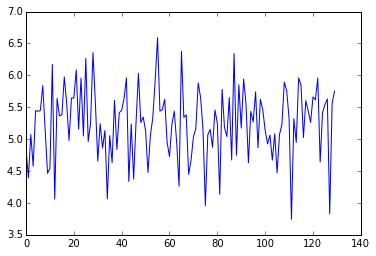

In [264]:
plt.plot(fs_hist)

In [ ]:
#sorted(fs_hist, decreasing=TRUE)
fs_hist

In [274]:
idx = [i for i, fs in enumerate(fs_hist) if fs == min(fs_hist)][0]

In [277]:
len(knowledge_pkg[idx]["buffer_group"])

55

In [285]:
import os

print os.getcwd()

/home/beingzy/Documents/projects/phd_experiment


In [293]:
pd.DataFrame(knowledge_pkg[idx]["fit_group"]).to_csv(os.getcwd() + 
                                                     "/results/dr_huang_part_ii/fit_group.csv", 
                                                     header = True, index = False, sep = ",")
pd.DataFrame(knowledge_pkg[idx]["buffer_group"]).to_csv(os.getcwd() + 
                                                     "/results/dr_huang_part_ii/buffer_group.csv", 
                                                     header = True, index = False, sep = ",")
pd.DataFrame(knowledge_pkg[idx]["dist_metrics"]).to_csv(os.getcwd() + 
                                                     "/results/dr_huang_part_ii/dist_metrics.csv", 
                                                     header = True, index = False, sep = ",")
pd.Series(fs_hist).to_csv(os.getcwd() + "/results/dr_huang_part_ii/fs_scores.csv")

In [296]:
pd.Series(fs_hist).to_csv(os.getcwd() + "/results/dr_huang_part_ii/fs_scores.csv")

{0: [0.0, 0.08, 0.0, 0.66, 0.0, 0.26, 0.0]}